In [1]:
from pyfeti.src.utils import DomainCreator, dict2dfmap, create_selection_operator
from pyfeti.src.feti_solver import SerialFETIsolver, SolverManager
from pyfeti.cases.case_generator import FETIcase_builder
from scipy import sparse
import amfe
import numpy as np
import matplotlib.pyplot as plt


class DofManager():
    def __init__(self,element_df,node_df):
        self.element_df = element_df
        self.node_df = node_df
        self.tag = 'phys_group'
    
    def get_dof_from_node(self,node_id):
        node_df = self.node_df
        return list(node_df.iloc[node_id])
        
    def get_connectivity_from_elem_id(self,elem_id): 
        element_df = self.element_df
        return list(element_df['connectivity'].iloc[elem_id])
    
    def get_dof_list_from_elem_id(self,elem_id):
        return list(map(self.get_dof_from_node,self.get_connectivity_from_elem_id(elem_id)))
    
    def get_elements_from_group_id(self,group_id):
        element_df = self.element_df
        tag = self.tag
        return list(element_df.loc[element_df[tag] == group_id].index)
    
    def get_dof_list_from_group_id(self,group_id): 
        return np.sort(np.array(list(map(self.get_dof_list_from_elem_id,self.get_elements_from_group_id(group_id)))).flatten())
    
    def get_node_list_from_group_id(self,group_id):
        node_list = []
        for elem_id in self.get_elements_from_group_id(group_id): 
            node_list.extend(self.get_connectivity_from_elem_id(elem_id))
        return np.sort(node_list)

Could not load paradiso!
Could not load paradiso!
Warning! Using python in global path


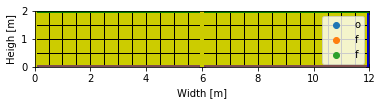

In [2]:
width = 6
heigh = 2
dobj = DomainCreator(width=width,heigh=heigh,x_divisions=13,y_divisions=5)
mesh_file = 'mesh.msh'
dobj.save_gmsh_file(mesh_file)

m1 = amfe.Mesh()
m1.import_msh(mesh_file)

m2 = m1.translation(np.array([6.,0.]))

ax1 = amfe.plot2Dmesh(m1)
amfe.plot2Dmesh(m2,ax=ax1)

ax1.set_xlim([0,2*width])
ax1.set_ylim([0,heigh])
ax1.set_aspect('equal')
ax1.set_xlabel('Width [m]')
ax1.set_ylabel('Heigh [m]')
plt.legend('off')

In [3]:
# creating material
my_material = amfe.KirchhoffMaterial(E=210.0E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=1.0)

my_system1 = amfe.MechanicalSystem()
my_system1.set_mesh_obj(m1)
my_system1.set_domain(3,my_material)

K1, _ = my_system1.assembly_class.assemble_k_and_f()
M1 = my_system1.assembly_class.assemble_m()


my_system2 = amfe.MechanicalSystem()
my_system2.set_mesh_obj(m2)
my_system2.set_domain(3,my_material)

K2, _ = my_system2.assembly_class.assemble_k_and_f()
M2 = my_system2.assembly_class.assemble_m()

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 48 elements and 130 dofs.
Time taken for preallocation: 0.01 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 48 elements and 130 dofs.
Time taken for preallocation: 0.00 seconds.


In [4]:
try:
    connectivity = []
    for _,item in m1.el_df.iloc[:, m1.node_idx:].iterrows():
        connectivity.append(list(item.dropna().astype(dtype='int64')))
    m1.el_df['connectivity'] = connectivity
except:
    pass
    
id_matrix = my_system1.assembly_class.id_matrix
id_map_df = dict2dfmap(id_matrix)
s = create_selection_operator(id_map_df,m1.el_df)

neighbors_dict = {}
neighbors_dict['right'] = 2
neighbors_dict['left'] = 1
neighbors_dict['top'] = 5
neighbors_dict['bottom'] = 4
neighbors_dict['bottom_left_corner'] = 6
neighbors_dict['bottom_right_corner'] = 7
neighbors_dict['top_left_corner'] = 8
neighbors_dict['top_right_corner'] = 9

B_local_dict = {}
for key, value in neighbors_dict.items():
    B_local_dict[key] = s.build_B(value)

In [5]:
zeros = np.zeros(K1.shape[0])
case = FETIcase_builder(2,1, K1, zeros, B_local_dict,s,BC_type='G',force_scaling=2.0)
K_dict, B_dict, f_dict = case.build_subdomain_matrices()

In [6]:
feti_obj = SerialFETIsolver(K_dict,B_dict,f_dict,tolerance=1.0e-12)
solution_obj = feti_obj.solve()
u_dict = solution_obj.u_dict

p0 = 1.5
u1=p0*u_dict[1]
u2=p0*u_dict[2]
my_system1.u_output = [u1]
my_system2.u_output = [u2]

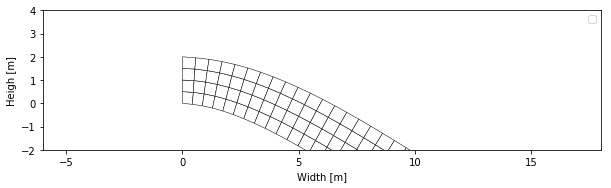

In [7]:
fig, ax2 = plt.subplots(1,1,figsize=(10,3))
amfe.plot_2D_system_solution(my_system1,u_id=0,ax=ax2)
amfe.plot_2D_system_solution(my_system2,u_id=0,ax=ax2)
delta_ = 1.0
ax2.set_xlim([-delta_*width,(2.0+delta_)*width])
ax2.set_ylim([-delta_*heigh,(1.0+delta_)*heigh ])
ax2.set_aspect('equal')
ax2.set_xlabel('Width [m]')
ax2.set_ylabel('Heigh [m]')
plt.legend('off')

In [8]:
M_dict = {1:M1, 2:M2}
#K_dict = {1:K1, 2:K2}
manager = SolverManager(K_dict,B_dict,f_dict,tolerance=1.0e-12)
managerM = SolverManager(M_dict,B_dict,f_dict,tolerance=1.0e-12)
M1 = managerM.local_problem_dict[1].K_local
M1.key_dict = s.selection_dict
M1.eliminate_by_identity(1,multiplier=0.0)
M_dict = {1:M1, 2:M2}

In [9]:
B = manager.assemble_global_B().A

M_,_ = managerM.assemble_global_K_and_f()
K, _ = manager.assemble_global_K_and_f()
M = M_.A
BBT_inv = np.linalg.inv(B.dot(B.T))
P = np.eye(M.shape[0]) + B.T.dot(BBT_inv.dot(B))
#P = np.eye(M.shape[0])

In [10]:
u0 = solution_obj.displacement 
def system(u):
    f = P.T.dot(M.dot(P.dot(u)))
    f_dict = manager.vector2localdict(f,manager.global2local_primal_dofs)
    feti_obj = SerialFETIsolver(K_dict,B_dict,f_dict,tolerance=1.0e-12)
    solution_obj = feti_obj.solve()
    u_dict = solution_obj.u_dict
    return solution_obj.displacement
    
un = system(u0)
    

In [11]:
D = sparse.linalg.LinearOperator(shape=M.shape,matvec = lambda x : system(x))

In [12]:
eigval, V = sparse.linalg.eigsh(D,k=20,v0 = P.dot(u0))

In [13]:
val = np.sort(1/eigval)
val

array([5.27502196e+03, 1.69498941e+05, 4.60134507e+05, 1.08707118e+06,
       3.01204595e+06, 4.13717400e+06, 7.01035872e+06, 1.14602436e+07,
       1.17574816e+07, 1.83903788e+07, 2.22710890e+07, 2.63542559e+07,
       2.96129476e+07, 3.34757048e+07, 3.59101672e+07, 3.96220490e+07,
       4.39084687e+07, 5.02171962e+07, 5.28520866e+07, 5.72121999e+07])

In [14]:
L = manager.assemble_global_L()
Lexp = manager.assemble_global_L_exp()

In [15]:
Kp = L.dot(K.dot(Lexp))
Mp = L.dot(M.dot(Lexp))
Dp = np.linalg.inv(Kp).dot(Mp)

In [16]:
#Dp.dot(L.dot(u0))

In [17]:
eigval_, Vp = sparse.linalg.eigsh(Dp,k=20,v0=L.dot(u0))
eigval_

array([1.74859279e-08, 1.89195377e-08, 1.98961457e-08, 2.28005526e-08,
       2.52760313e-08, 2.78490759e-08, 3.00465120e-08, 3.36616618e-08,
       3.78222800e-08, 4.48964668e-08, 5.48387005e-08, 8.49665577e-08,
       8.72505460e-08, 1.44082237e-07, 2.41673425e-07, 3.30240093e-07,
       9.23298239e-07, 2.17328288e-06, 5.79525495e-06, 1.89673474e-04])

In [18]:
val_p = np.sort(1/eigval_)
val_p

array([5.27221852e+03, 1.72554962e+05, 4.60133380e+05, 1.08307366e+06,
       3.02809993e+06, 4.13781532e+06, 6.94048080e+06, 1.14612463e+07,
       1.17693364e+07, 1.82352972e+07, 2.22734676e+07, 2.64394426e+07,
       2.97073866e+07, 3.32817333e+07, 3.59078342e+07, 3.95631730e+07,
       4.38585861e+07, 5.02609909e+07, 5.28554142e+07, 5.71888438e+07])

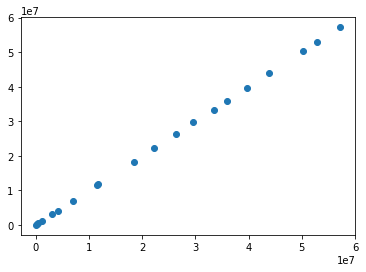

In [19]:
plt.plot(val,val_p,'o')

In [20]:
np.sqrt(val)/(2.0*np.pi)

array([  11.55931949,   65.52448653,  107.9599149 ,  165.93925012,
        276.21733347,  323.72185842,  421.39584809,  538.78693592,
        545.72931778,  682.52013657,  751.08806089,  817.04412332,
        866.08586556,  920.84173907,  953.73746951, 1001.81746146,
       1054.61580984, 1127.83706286, 1157.04753235, 1203.82804117])

In [21]:
#V_ = Lexp.dot(Vp)
v_dict = manager.vector2localdict(V,manager.global2local_primal_dofs)

In [22]:
p0 = 10.0
u1=p0*v_dict[1]
u2=p0*v_dict[2]
my_system1.u_output = list(u1.T)
my_system2.u_output = list(u2.T)

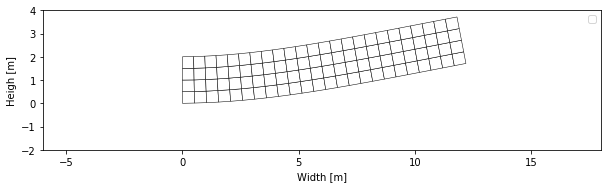

In [23]:
mode_id = 0
fig, ax2 = plt.subplots(1,1,figsize=(10,3))
amfe.plot_2D_system_solution(my_system1,u_id=(19 - mode_id),ax=ax2)
amfe.plot_2D_system_solution(my_system2,u_id=(19 - mode_id),ax=ax2)
delta_ = 1.0
ax2.set_xlim([-delta_*width,(2.0+delta_)*width])
ax2.set_ylim([-delta_*heigh,(1.0+delta_)*heigh ])
ax2.set_aspect('equal')
ax2.set_xlabel('Width [m]')
ax2.set_ylabel('Heigh [m]')
plt.legend('off')

In [24]:
B_dict

{1: {(1, 2): <10x130 sparse matrix of type '<class 'numpy.int8'>'
  	with 10 stored elements in Compressed Sparse Row format>},
 2: {(2, 1): <10x130 sparse matrix of type '<class 'numpy.int8'>'
  	with 10 stored elements in Compressed Sparse Row format>}}

In [25]:
# Total FETI approach

In [26]:
K1, _ = my_system1.assembly_class.assemble_k_and_f()
M1 = my_system1.assembly_class.assemble_m()


my_system2 = amfe.MechanicalSystem()
my_system2.set_mesh_obj(m2)
my_system2.set_domain(3,my_material)

K2, _ = my_system2.assembly_class.assemble_k_and_f()
M2 = my_system2.assembly_class.assemble_m()

K_dict_ = {1:K1, 2:K2}
B_dict_ = B_dict

B_dict_[1].update( {(1,1): s.build_B(1)}) # add Dirichlet Constraint
M_dict = {1:M1, 2:M2}




Preallocating the stiffness matrix
Done preallocating stiffness matrix with 96 elements and 130 dofs.
Time taken for preallocation: 0.00 seconds.


In [27]:
B_dict_

{1: {(1, 2): <10x130 sparse matrix of type '<class 'numpy.int8'>'
  	with 10 stored elements in Compressed Sparse Row format>,
  (1, 1): <10x130 sparse matrix of type '<class 'numpy.int8'>'
  	with 10 stored elements in Compressed Sparse Row format>},
 2: {(2, 1): <10x130 sparse matrix of type '<class 'numpy.int8'>'
  	with 10 stored elements in Compressed Sparse Row format>}}

In [28]:
managerT = SolverManager(K_dict_,B_dict_,f_dict,tolerance=1.0e-12)
B_ = managerT.assemble_global_B().A

BBT_inv_ = np.linalg.inv(B_.dot(B_.T))
P_ = np.eye(M.shape[0]) + B_.T.dot(BBT_inv_.dot(B_))
#P = np.eye(M.shape[0])

def systemT(u):
    f_ = P_.T.dot(M.dot(P_.dot(u)))
    f_dict_ = manager.vector2localdict(f_,managerT.global2local_primal_dofs)
    feti_obj_ = SerialFETIsolver(K_dict_,B_dict_,f_dict_,tolerance=1.0e-12)
    solution_obj_ = feti_obj_.solve()
    u_dict_ = solution_obj_.u_dict
    return solution_obj_.displacement
    
un = system(u0)

In [29]:
DT = sparse.linalg.LinearOperator(shape=M.shape,matvec = lambda x : systemT(x))

eigvalT, VT = sparse.linalg.eigsh(DT,k=20,v0 = P_.dot(u0))
val_T = np.sort(1/eigvalT)

In [30]:
np.sqrt(val_T)/(2.0*np.pi)

array([  11.73354858,   71.81633013,  113.05620904,  207.57136132,
        318.66933   ,  389.21171512,  497.67468651,  628.19481464,
        654.59732685,  798.67545961,  876.70888608,  929.9456114 ,
       1000.32775208, 1122.99807882, 1143.61917551, 1211.80340121,
       1280.32651503, 1299.36210606, 1360.55461672, 1373.75924382])

In [31]:
v_dict = manager.vector2localdict(V,managerT.global2local_primal_dofs)
p0 = 10.0
u1=p0*v_dict[1]
u2=p0*v_dict[2]
my_system1.u_output = list(u1.T)
my_system2.u_output = list(u2.T)

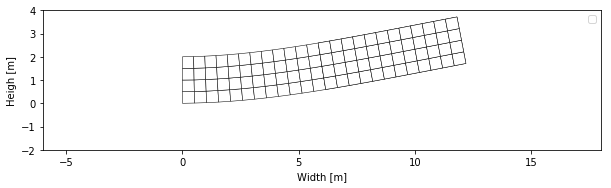

In [33]:
mode_id = 0
fig, ax2 = plt.subplots(1,1,figsize=(10,3))
amfe.plot_2D_system_solution(my_system1,u_id=(19 - mode_id),ax=ax2)
amfe.plot_2D_system_solution(my_system2,u_id=(19 - mode_id),ax=ax2)
delta_ = 1.0
ax2.set_xlim([-delta_*width,(2.0+delta_)*width])
ax2.set_ylim([-delta_*heigh,(1.0+delta_)*heigh ])
ax2.set_aspect('equal')
ax2.set_xlabel('Width [m]')
ax2.set_ylabel('Heigh [m]')
plt.legend('off')